# Computer Theory Project - Phase 1

`Members`
1. Antony Kiroles 202000897
2. Donia Khaled 202001874
3. Eslam Ahmed 202000039
3. Mariam Barakat 202000210


`Steps:---------------------------`
1. *String processing :* Insert '.' which are multiplications in expressions that are written without it
2. *Regex to postfix* : We change the regular expression to a postfix to be able to effectively make the machine understand the priorities
3. *postfix to ast* : We change the Postfix to an AST, a tree structure that represents what part of the expression to start processing first
4. *Pasrse Tree to NFA* : Change the AST to be represented as NFA [Thompson's Construction]
5. *Change NFA to DFA* : Change the NFA to DFA [Subset Construction Theorem]

## String Processing 

In [1]:
import copy
operators = {'|','*','(',')','.','+'}
def StringPreprocessing(regex:str):
    output = list(regex)
    insertOffset = 0
    for i in range(1,len(regex)):
        if regex[i] not in operators:
            if regex[i-1] not in operators:
                output.insert(i+insertOffset,'.')
                insertOffset += 1
        elif regex[i] == '(':
            if regex[i-1] not in operators:
                output.insert(i+insertOffset,'.')
                insertOffset += 1
        elif regex[i] == ')':
            if regex[i+1] not in operators:
                output.insert(i+1+insertOffset,'.')
                insertOffset += 1
        elif regex[i] == '+':
            if regex[i-1] not in operators:
                # output.insert()
                insertOffset += 1
    return ''.join(output)

## Regular Expression To Postfix

In [2]:
import string

def regex_to_postfix(regex: str):
    
    precedence = {"*": 3,"+": 3, ".": 2, "|": 1, "(": 0}  # operator precedence
    stack = []
    S=list()
    for i in range(len(regex)):
        if regex[i] in string.digits or regex[i] in string.ascii_letters: #if digit then put to the output 
            S.append(regex[i])
            
        elif regex[i]=="(": #if an open bracket then put to the stack
            stack.append(regex[i])
    
        elif regex[i] == ")": #if closed then pop until you find an open bracket
            while stack and stack[-1] != "(":
                S.append(stack.pop())
                
            if stack and stack[-1] == "(":
                    stack.pop() 
        
        else:  # if char is an operator, pop operators from stack with higher precedence and append to postfix list
                while stack and precedence[regex[i]] <= precedence.get(stack[-1], 0):
                    S.append(stack.pop())
                stack.append(regex[i])
    while stack:  # pop any remaining operators from stack and append to postfix list
        S.append(stack.pop())   

    return "".join(S) 

## Postfix to AST

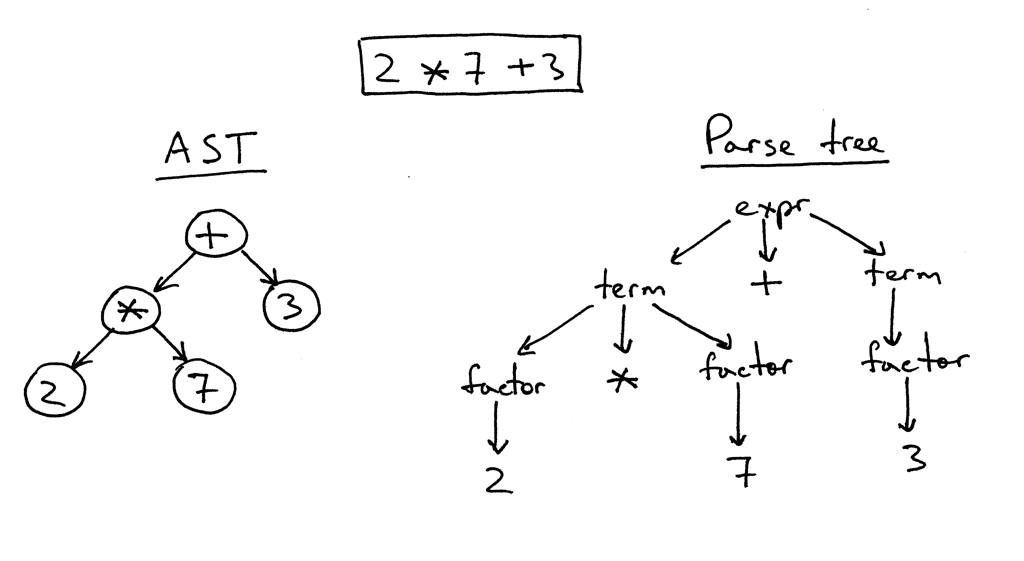

In [3]:
def postfix_to_ast(postfix):
    stack = []

    for char in postfix:
        if char.isalnum():
            node = {"Node": char}
            stack.append(node)
        else:
            if char == '|': # needs to have 2 children
                right = stack.pop()
                left = stack.pop()
                node = {"Node": char, "left": left, "right": right}
            elif char == '.': #  needs to have 2 children
                right = stack.pop()
                left = stack.pop()
                node = {"Node": char, "left": left, "right": right}
            elif char == '*': # needs only one child as it is a unary operator
                child = stack.pop()
                node = {"Node": char, "left": child}
            elif char == '+' : # needs only one child as it is a unary operator
                child = stack.pop()
                node = {"Node": char, "left": child}
            stack.append(node)
    return stack.pop()

## From AST to NFA

In [4]:
from pydantic import BaseModel

class NFATable(BaseModel):
    stateNameCounter: int = 0
    states: set = set()
    alphabet: set = set()
    transitionTable: dict = {}
    startState: int = None
    acceptingStates: set = set()

def JoinAnd(leftTable: NFATable,rightTable: NFATable)->NFATable:
    nfaTable = NFATable()
    nfaTable.startState = leftTable.startState
    nfaTable.alphabet = nfaTable.alphabet.union(leftTable.alphabet, rightTable.alphabet)
    nfaTable.acceptingStates = rightTable.acceptingStates
    nfaTable.stateNameCounter = max(*leftTable.states,*rightTable.states)+1
    nfaTable.states = leftTable.states.union(rightTable.states)
    nfaTable.transitionTable.update(leftTable.transitionTable)
    nfaTable.transitionTable.update(rightTable.transitionTable)
    nfaTable.transitionTable.pop(rightTable.startState)
    nfaTable.transitionTable.update(
        {
            list(leftTable.acceptingStates)[0]:rightTable.transitionTable[rightTable.startState]
        })    
    nfaTable.states = nfaTable.states.intersection(nfaTable.transitionTable.keys()).union(nfaTable.acceptingStates)
    return nfaTable

def JoinOr(leftTable: NFATable, rightTable: NFATable) -> NFATable:
    
    nfaTable = NFATable()
    nfaTable.startState = max(*leftTable.states,*rightTable.states)+1
    nfaTable.alphabet = nfaTable.alphabet.union(leftTable.alphabet, rightTable.alphabet)
    nfaTable.acceptingStates = set([nfaTable.startState+1])
    nfaTable.stateNameCounter = nfaTable.startState+2
    nfaTable.states = nfaTable.states.union(leftTable.states, rightTable.states, [
                          nfaTable.startState, nfaTable.startState+1])
    nfaTable.transitionTable.update(leftTable.transitionTable)
    nfaTable.transitionTable.update(rightTable.transitionTable)
    nfaTable.transitionTable.update(
        {
            nfaTable.startState:
                {
                    '': set([leftTable.startState, rightTable.startState])
                },
            list(leftTable.acceptingStates)[0]:
                {
                    '': set([nfaTable.stateNameCounter-1])
            },
            list(rightTable.acceptingStates)[0]:
                {
                    '': set([nfaTable.stateNameCounter-1])
            }
        })
    nfaTable.states = nfaTable.states.intersection(nfaTable.transitionTable.keys()).union(nfaTable.acceptingStates)
    return nfaTable

def JoinStar(leftTable:NFATable)->NFATable:
    nfaTable = NFATable()
    nfaTable.startState = max(*leftTable.states)+1
    nfaTable.alphabet = leftTable.alphabet
    nfaTable.acceptingStates = set([nfaTable.startState+1])
    nfaTable.stateNameCounter = nfaTable.startState+2
    nfaTable.states = nfaTable.states.union(leftTable.states, [
                          nfaTable.startState, nfaTable.startState+1])
    nfaTable.transitionTable.update(leftTable.transitionTable)
    nfaTable.transitionTable.update(
        {
            nfaTable.startState:
                {
                    '': set([leftTable.startState,nfaTable.stateNameCounter-1]),
                },
            list(leftTable.acceptingStates)[0]:
                {
                    '': set([leftTable.startState,nfaTable.stateNameCounter-1])
                }
        })
    nfaTable.states = nfaTable.states.intersection(nfaTable.transitionTable.keys()).union(nfaTable.acceptingStates)
    return nfaTable

In [5]:
def ParseTreeToNFA(tree:dict,stateNameCounter:int=0)-> NFATable:    
    leftTable = None
    rightTable = None
    if 'left' in tree.keys():
        leftTable = ParseTreeToNFA(tree['left'],stateNameCounter)
        stateNameCounter+=leftTable.stateNameCounter
    if 'right' in tree.keys():
        rightTable = ParseTreeToNFA(tree['right'],stateNameCounter)
        stateNameCounter+=rightTable.stateNameCounter
    node = tree['Node']
    if  node =='|' :
        return JoinOr(leftTable,rightTable)
    elif node == '.': 
        return JoinAnd(leftTable,rightTable)
    elif node =='*':
        return JoinStar(leftTable)
    else:
        return NFATable(
                stateNameCounter = stateNameCounter+2,
                startState = stateNameCounter,
                states = set(range(stateNameCounter,stateNameCounter+2)),
                alphabet = set([tree['Node']]),
                transitionTable={
                    stateNameCounter:{tree['Node']:set([stateNameCounter+1])},
                    stateNameCounter+1:{}
                },
                acceptingStates=set([stateNameCounter+1]))    

## NFA to DFA

In [6]:
import copy

def ComputeEpsilons(transitionDict, startState):
    if startState not in transitionDict.keys():
        return {startState}
    if '' not in transitionDict[startState].keys():
        return {startState}
    else:
        states = set()
        for state in transitionDict[startState]['']:
            states = states.union(ComputeEpsilons(transitionDict, state))
        return {startState}.union(states)

def isSubset(state,newStatesDict):
    for v in newStatesDict.values():
        if state.intersection(v) == state and v != state or (list(newStatesDict.values()).count(state) > 1):
            return True

    return False

def ComputeNewStates(transitionDict):
    visitedStates = set()
    groupCounter = max(transitionDict.keys()) + 1
    newStatesDict = {}
    for state, transitions in transitionDict.items():
        if state not in visitedStates:
            newState = set() 
            newState = ComputeEpsilons(transitionDict, state)
            newStatesDict[groupCounter] = newState
            for symbol, nextState in transitions.items():
                if symbol != '':
                    states = set()
                    if '' in transitionDict[state].keys():
                        for s in transitionDict[state]['']:
                            states = states.union(ComputeEpsilons(transitionDict, s))
        sharedTransitions = {}
        for s in newStatesDict[groupCounter]:
            if s in transitionDict.keys():
                for symbol, nextState in transitionDict[s].items():
                    if symbol != '':
                        if symbol not in sharedTransitions.keys():
                            sharedTransitions[symbol] = set()
                        sharedTransitions[symbol] = sharedTransitions[symbol].union(ComputeEpsilons(transitionDict,list(nextState)[0]))
        # print(sharedTransitions)
        for nextState in sharedTransitions.values():
            if nextState not in newStatesDict.values():
                groupCounter += 1
                newStatesDict[groupCounter] = nextState
        visitedStates.add(state)
        groupCounter+=1
    for k,v in copy.copy(newStatesDict).items():
        if isSubset(v,newStatesDict):
            del newStatesDict[k]
    
    return newStatesDict


In [7]:
def ComputeNewStart(start,symbolTransitions):
    for k,v in symbolTransitions.items():
        if start in v:
            return k

In [8]:
def ComputeNewTransitions(transitions,symbolTransitions):
    newTransitions = {}
    for i in transitions.keys():
        for ns, j in symbolTransitions.items():
                if i in j:
                    for transition in transitions[i]:
                            if transition != '':
                                if ns not in newTransitions.keys():
                                    newTransitions[ns] = {}
                                newTransitions[ns][transition] = transitions[i][transition]
    return newTransitions

In [9]:
def RenameTransitions(symbolTransitions,newTransitions):
    for i,k in enumerate(list(symbolTransitions.keys())):
        symbolTransitions[i] = symbolTransitions[k]
        newTransitions[i] = newTransitions[k]
        del symbolTransitions[k]
        del newTransitions[k]
    for k,v in newTransitions.items():
        for symbol, state in v.items():
            for s in state:
                for n,o in symbolTransitions.items():
                    if s in o:
                        newTransitions[k][symbol] = n
    return symbolTransitions,newTransitions

In [10]:
def ComputeNewAcceptance(acceptance,symbolTransitions):
    newAcceptance = set()
    for k,v in symbolTransitions.items():
        for state in acceptance:
            if state in v:
                newAcceptance.add(k)
    return newAcceptance

## Trial

In [11]:
input = "(aa|ba)*"

In [12]:
processedInput = StringPreprocessing(input)
processedInput

'(a.a|b.a)*'

In [13]:
postfix=regex_to_postfix(processedInput)
postfix

'aa.ba.|*'

In [14]:
ast = postfix_to_ast(postfix)
ast

{'Node': '*',
 'left': {'Node': '|',
  'left': {'Node': '.', 'left': {'Node': 'a'}, 'right': {'Node': 'a'}},
  'right': {'Node': '.', 'left': {'Node': 'b'}, 'right': {'Node': 'a'}}}}

In [15]:
nfa = ParseTreeToNFA(ast)
nfa

NFATable(stateNameCounter=16, states={0, 1, 3, 4, 5, 11, 12, 13, 14, 15}, alphabet={'a', 'b'}, transitionTable={0: {'a': {1}}, 1: {'a': {3}}, 3: {'': {13}}, 4: {'b': {5}}, 5: {'a': {11}}, 11: {'': {13}}, 12: {'': {0, 4}}, 14: {'': {12, 15}}, 13: {'': {12, 15}}}, startState=14, acceptingStates={15})

In [16]:
transitions = nfa.transitionTable
start = nfa.startState
acceptance = nfa.acceptingStates

In [17]:
symbolTransitions = ComputeNewStates(transitions)
symbolTransitions

{17: {1},
 19: {0, 3, 4, 12, 13, 15},
 22: {5},
 24: {0, 4, 11, 12, 13, 15},
 26: {0, 4, 12, 14, 15}}

In [18]:
newTransitions = ComputeNewTransitions(transitions,symbolTransitions)
newTransitions

{19: {'a': {1}, 'b': {5}},
 24: {'a': {1}, 'b': {5}},
 26: {'a': {1}, 'b': {5}},
 17: {'a': {3}},
 22: {'a': {11}}}

In [19]:

symbolTransitions,newTransitions=RenameTransitions(symbolTransitions,newTransitions)
symbolTransitions,newTransitions

({0: {1},
  1: {0, 3, 4, 12, 13, 15},
  2: {5},
  3: {0, 4, 11, 12, 13, 15},
  4: {0, 4, 12, 14, 15}},
 {0: {'a': 1},
  1: {'a': 0, 'b': 2},
  2: {'a': 3},
  3: {'a': 0, 'b': 2},
  4: {'a': 0, 'b': 2}})

In [20]:

newAcceptance = ComputeNewAcceptance(acceptance,symbolTransitions)
symbolTransitions

{0: {1},
 1: {0, 3, 4, 12, 13, 15},
 2: {5},
 3: {0, 4, 11, 12, 13, 15},
 4: {0, 4, 12, 14, 15}}

In [21]:
newStart= ComputeNewStart(start,symbolTransitions)
newStart

4

In [22]:

newAcceptance = ComputeNewAcceptance(acceptance,symbolTransitions)
newAcceptance
newTransitions

{0: {'a': 1},
 1: {'a': 0, 'b': 2},
 2: {'a': 3},
 3: {'a': 0, 'b': 2},
 4: {'a': 0, 'b': 2}}

## Visualising DFA

In [23]:
%pip install pyvis

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from pyvis.network import Network
from IPython import display
from IPython.core.display import display, HTML



# create a network object
net = Network(height='1500px', width='70%', bgcolor='#222222', font_color='white',notebook=False,directed=True)

# add nodes to the network
for node in newTransitions.keys():
  if node == newStart:
    net.add_node(node, label=str(node),color='#00ff1e',title="Start State")
  elif node in newAcceptance:
       net.add_node(node, label=str(node),color='purple',title="Acceptance State")
  else:
    net.add_node(node, label=str(node))
      

# add edges to the network
for node, edges in newTransitions.items():
    for edge, target in edges.items():
        net.add_edge(node, target, label=edge)

# add physics simulation to the network
net.barnes_hut(spring_strength=0.01)

net.show_buttons(filter_=['physics'])
# show the network
net.show("DFA.html")

C:\Users\eslam\AppData\Local\Temp\ipykernel_19180\756413002.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Final Functions together

In [ ]:
def regx_DFA(input):
    processedInput = StringPreprocessing(input)
    postfix=regex_to_postfix(processedInput)
    ast = postfix_to_ast(postfix)
    nfa = ParseTreeToNFA(ast)
    transitions = nfa.transitionTable
    start = nfa.startState
    acceptance = nfa.acceptingStates
    symbolTransitions = ComputeNewStates(transitions)
    newTransitions = ComputeNewTransitions(transitions,symbolTransitions)
    symbolTransitions,newTransitions=RenameTransitions(symbolTransitions,newTransitions)
    newAcceptance = ComputeNewAcceptance(acceptance,symbolTransitions)
    newStart= ComputeNewStart(start,symbolTransitions)
    newAcceptance = ComputeNewAcceptance(acceptance,symbolTransitions)
    return [newStart, newAcceptance, newTransitions]


In [ ]:
def checking(input,example):
    pointer = 0
    list_ = regx_DFA(input)
    newStart = list_[0]
    newAcceptance = list_[1]
    newTransitions = list_[2]
    current_state = newStart
    print("index -> current state ")
    print(str(pointer) +"->" + str(current_state))
    while True:
        if pointer == len(example):
            if current_state in newAcceptance:
                print("accepted")
                break
            else:
                print("rejected")
                break
        elif current_state in newTransitions.keys() :
            if example[pointer] in list(newTransitions[current_state].keys()):
                current_state = newTransitions[current_state][example[pointer]]
                pointer = pointer + 1
                print(str(pointer) +"->" + str(current_state))
            else:
                print("rejected")
                break
        else:
            print("rejected")
            break


## Examples 

In [ ]:
checking("(aa|ba)*","aabaaa")

index -> current state 
0->4
1->0
2->1
3->2
4->3
5->0
6->1
accepted


In [ ]:
checking("(aa|ba)*","abaa")

index -> current state 
0->4
1->0
rejected


In [ ]:
checking("(a(ba|bb))*","aba")

index -> current state 
0->4
1->0
2->1
3->2
accepted


In [ ]:
checking("(a(ba|bb))*","aabb")

index -> current state 
0->4
1->0
rejected
